In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

In [2]:
PROJECT_ID = 'york-bb-cohort'
BQ_LOCATION = 'US'
REGION = 'us-east1'
GCS_BUCKET = f"{PROJECT_ID}-akane_bucket"
# Bucket created via console
BQ_DATASET = f"{PROJECT_ID}:akane_bqds"

### Binary classification metrics refreshers
* Accuracy: All correct predictions over all predictions
* Precision: True positives over all marked positive (How many marked positive were correct)
* Recall: True positives over all actual positives (How many actual pos. were correctly IDed)
* F1: Mean of precision and recall. 2TP / (2TP + FP + FN)

### Model 1: Boosted tree classifier

(optimal trials found by examining models in BigQuery UI)

In [7]:
# Evaluation metrics
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL akane_bqds.ak_bqmodel1)
WHERE trial_id=6;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,6,0.501779,0.156493,0.966025,0.238579,0.071887,0.969034


In [3]:
# Confusion matrix
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL akane_bqds.ak_bqmodel1)
WHERE trial_id=6;

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,25449,140
1,1,760,141


In [5]:
#AUC-ROC curve
%%bigquery df_roc --project $PROJECT_ID

SELECT * FROM ML.ROC_CURVE(MODEL akane_bqds.ak_bqmodel1)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

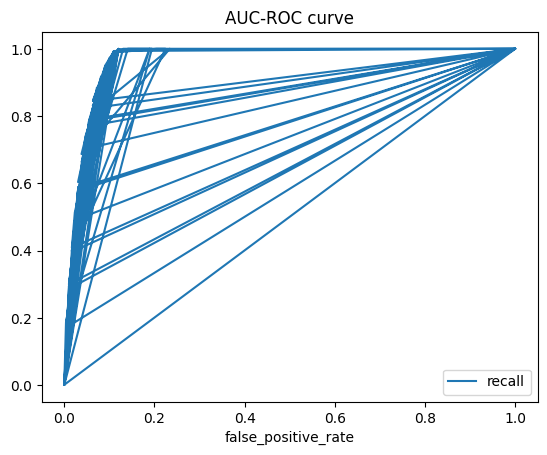

In [9]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

In [ ]:
# Predictions on test set - table retrieved from BigQuery model UI
# Saved to akane_bqds.model1_test_results

SELECT 
  * 
FROM 
  ML.PREDICT(MODEL akane_bqds.ak_bqmodel1,
  (SELECT * FROM york-bb-cohort._28a1c0d0341af90c53422cdc7e56b03c76a94414.anon65008a56_7f54_4de3_abbc_55b4bb0461eb_imported_data_split_test_data))

#@bigquery
SELECT
COUNTIF(label = 1 AND predicted_label = 1) / COUNTIF(predicted_label = 1) AS precision,
COUNTIF(label = 1 AND predicted_label = 1) / COUNTIF(label = 1) AS recall,
2 * COUNTIF(label = 1 AND predicted_label = 1) / (COUNTIF(label = 1) + COUNTIF(predicted_label = 1)) AS f1
FROM
akane_bqds.model1_test_results;


### Model 2: Weighted boosted tree classifier

In [10]:
# Evaluation metrics
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL akane_bqds.ak_bqmodel2)
WHERE trial_id=7;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,7,0.240961,0.991121,0.893507,0.387671,0.215979,0.967366


In [11]:
# Confusion matrix
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL akane_bqds.ak_bqmodel2)
WHERE trial_id=7;

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,22776,2813
1,1,8,893


In [12]:
# AUC-ROC curve
%%bigquery df_roc --project $PROJECT_ID

SELECT * FROM ML.ROC_CURVE(MODEL akane_bqds.ak_bqmodel2)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

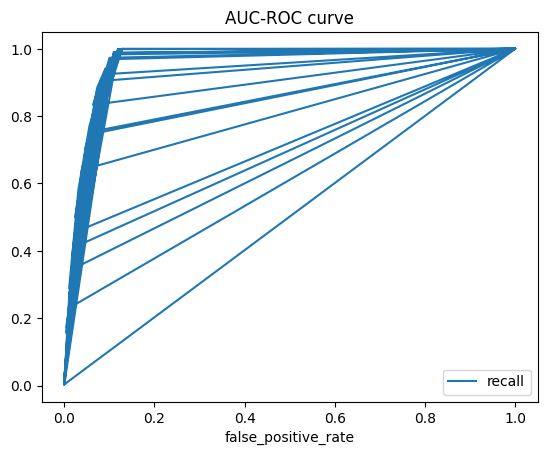

In [13]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")